In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
# Using the code from colab example 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

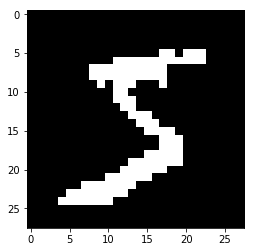

In [5]:
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_GRAY2RGB))

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [8]:
class AutoEncoderMNIST(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME",activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ])
        
    def call(self, img):
        latent = self.encoder(img)
        out = self.decoder(latent)
        
        out = tf.nn.sigmoid(out)
        return latent, out

In [9]:
auto = AutoEncoderMNIST(50)

In [10]:
optimizer = tf.train.AdamOptimizer(1e-4)
for i, img in enumerate(train_dataset):
    
    with tf.GradientTape() as tape:
        tape.watch(auto.variables)
        latent, out = auto(img)

        loss = tf.losses.mean_squared_error(img, out)
        if i % 100 == 0:
            print(loss)
        
    grad = tape.gradient(loss, auto.variables)
    optimizer.apply_gradients(zip(grad, auto.variables))

tf.Tensor(0.25000128, shape=(), dtype=float32)
tf.Tensor(0.10261193, shape=(), dtype=float32)
tf.Tensor(0.088939056, shape=(), dtype=float32)
tf.Tensor(0.082267344, shape=(), dtype=float32)
tf.Tensor(0.08457628, shape=(), dtype=float32)
tf.Tensor(0.08282662, shape=(), dtype=float32)


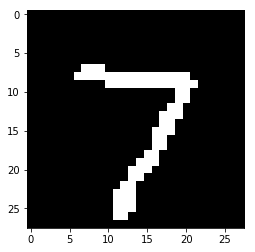

In [11]:
plt.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_GRAY2RGB))

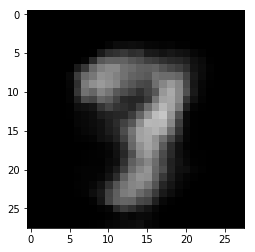

In [12]:
img_tensor = tf.convert_to_tensor(test_images[0])
img_tensor = tf.expand_dims(img_tensor, axis=0)

out = auto(img_tensor)[1]
out = tf.squeeze(out, axis=0)

plt.imshow(cv2.cvtColor(out.numpy(), 
    cv2.COLOR_GRAY2RGB
))